<a href="https://colab.research.google.com/github/kok554/computervision/blob/main/Alexnet%EA%B3%B5%EB%B6%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colabdptj Google Drive를 사용하기 위해 drive 모듈을 가져옵니다
from google.colab import drive

# Google Drive를 '/content/drive' 경로에 마운트합니다.
# 이 명령어를 실행하면 인증을 위한 링크가 제공되며,
# 사용자는 해당 링크를 클릭하여 Google 계정에 로그인하고 인증 코드를 얻어야 합니다
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 운영 체제와 관련된 기능을 제공하는 os 모듈을 임포트합니다
import os

# 파일 경로 패턴에 맞는 파일 목록을 찾기 위한 glob 모듈을 임포트합니다
import glob

import matplotlib.pyplot as plt
# 이미지 처리를 위한 PIL(Pillow) 라이브러리의 Image 모듈을 임포트합니다
from PIL import Image

# PyTorch 라이브러리의 주요 모듈을 임포트합니다
import torch # PyTorch의 기본 모듈
import torch.nn as nn # 신경망 구축을 위한 nn 모듈
import torch.optim as optim # 최적화 알고리즘을 제공하는 optim 모듈
from torch.utils.data import DataLoader, Dataset # 데이터 로딩 및 처리를 위한 모듈

# torchvision 라이브러리에서 이미지 데이터셋을 다루기 위한 ImageFolder 클래스를 임포트합니다
from torchvision.datasets import ImageFolder

# 이미지 변환을 위한 transforms 모듈을 임포트합니다
import torchvision.transforms as transforms

# 사전 훈련된 모델을 사용하기 위한 models 모듈을 임포트합니다
import torchvision.models as models

In [3]:
def display_images_center_crop(image_paths, title, max_images=4):
  """ 이미지 중앙의 특정 영역을 크롭하여 시각화하는 함수 """

  #  전체 그림의 크기를 설정합니다 (가로 12, 세로 3)
  plt.figure(figsize=(12, 3))

  # 주어진 이미지 경로 목록에서 최대 max_images 개수만큼 반복
  for i, image_path in enumerate(image_paths[:max_images]):
    # 이미지 파일을 엽니다
    image = Image.open(image_path)
    width, height = image.size # 이미지 너비와 높이를 가져옴

    # 이미지 중앙의 정사각형 영역을 계산합니다
    new_edge_length = min(width, height) # 너비와 높이 중 작은 값을 선택합니다
    left = (width - new_edge_length) # 왼쪽 경계
    top = (height - new_edge_length) # 위쪽 경계
    right = (width + new_edge_length) # 오른쪽 경계
    bottom = (height + new_edge_length) # 아래쪽 경계

    # 중앙 영역을 크롭합니다
    image_cropped = image.crop((10, 20, width-10, height-15))

    # 크롭된 이미지를 시각화
    plt.subplot(1, max_images, i+1) # 1행 max_images열의 서브플롯을 생성
    plt.imshow(image_cropped) # 크롭된 이미지 표시
    plt.title(title)
    plt.axis('off')

plt.show()

Train Glasses 총 이미지 수: 52
Train NoGlasses 총 이미지 수: 52
Val Glasses 총 이미지 수: 20
Val NoGlasses 총 이미지 수: 20
Test Glasses 총 이미지 수: 10
Test NoGlasses 총 이미지 수: 10


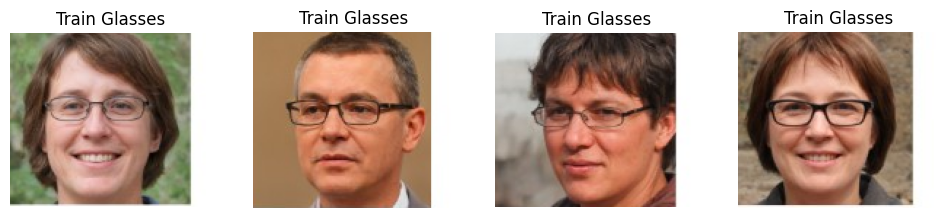

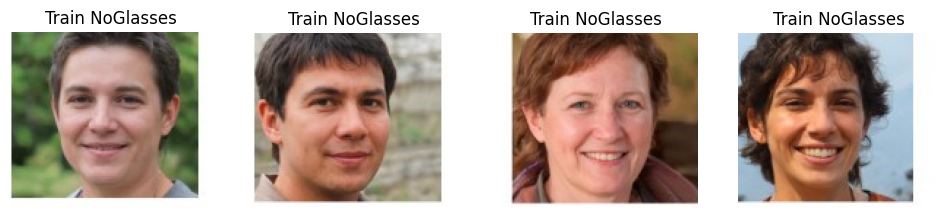

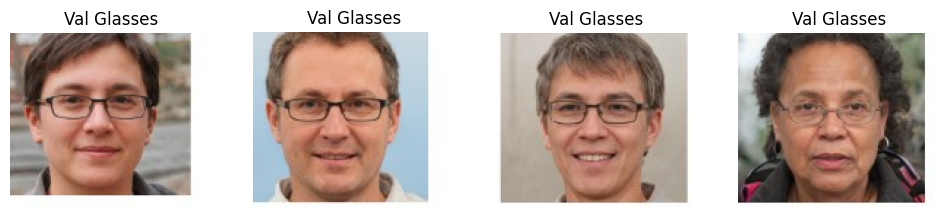

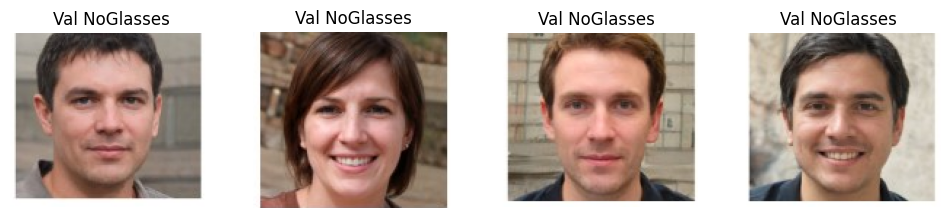

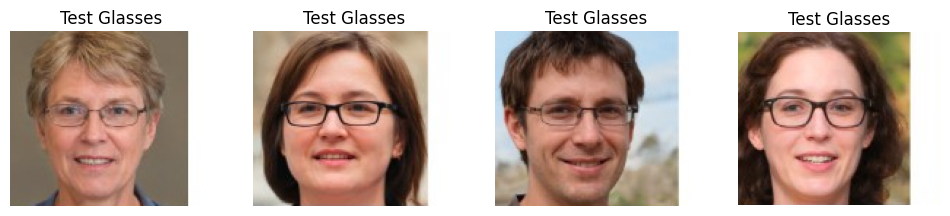

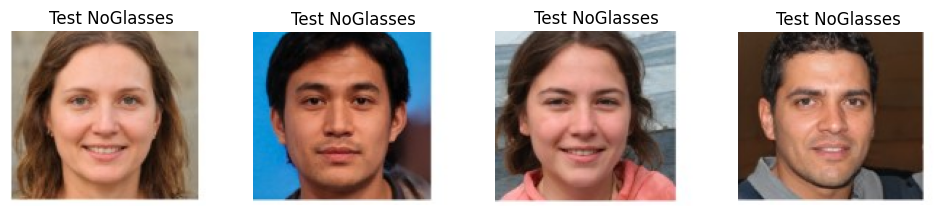

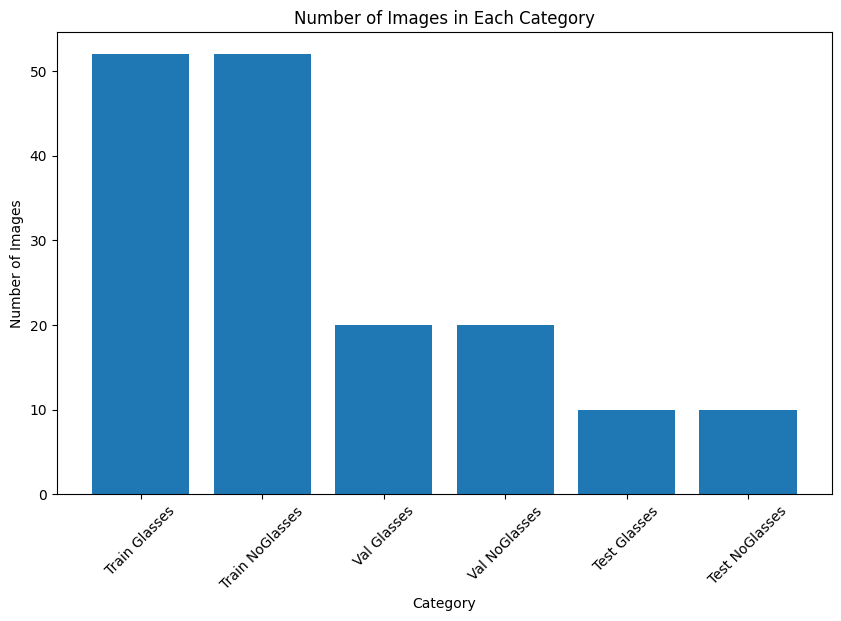

In [4]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

for category in categories:
  # 해당 카테고리에 맞는 이미지 파일 경로를 가져옴
  image_paths = glob.glob(f'/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/{category.lower().replace(" ","/")}/*')

  # 이미지들을 중앙 크롭하여 출력하는 함수 호출
  display_images_center_crop(image_paths, category)

  # 현재 카테고리의 총 이미지 수 출력
  print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
# 각 카테고리의 이미지 수를 계산하여 바 그래프를 그림
plt.bar(categories, [len(glob.glob(f'/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/{category.lower().replace(" ","/")}/*')) for category in categories])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45)
plt.show()

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop(128), # 이미지 중앙에서 128x128 크기로 잘라냄
    transforms.Resize((224, 224)), # 잘라낸 이미지를 224x224 크기로 조정
    transforms.RandomHorizontalFlip(), # 이미지를 무작위로 수평으로 뒤집음
    transforms.RandomRotation(30), # 이미지를 무작위로 -30도에서 +30도 사이로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 밝기, 대비, 채도, 색조를 무작위로 조정
    transforms.RandomGrayscale(p=0.2), #20% 확률로 이미지를 그레이스케일로 변환
    transforms.ToTensor(), # 이미지를 텐서로 변환 (0~255 범위를 0~1 범위로 변환)
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # 각 채널을 평균 0.5,표준편차 0.5로 정규화
      ])

# 데이터셋 로드 및 데이터 로더 생성
train_dataset = ImageFolder('/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/train', transform=transform)  # 훈련 데이터셋 로드
val_dataset = ImageFolder('/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/val', transform=transform)  # 검증 데이터셋 로드

# 훈련 데이터 로더 생성 (배치 크기8, 데이터 섞기)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [6]:
import torch.nn as nn # PyTorch의 신경망 모듈을 임포트
import torch.nn.functional as F # PyTorch의 함수형 신경망 모듈을 임포트

class AlexNet(nn.Module): # nn.Module을 상속받아 AlexNet 클래스를 정의
  def __init__(self, num_classes=1000): # 생성자, 기본 클래스 수는 1000 (ImageNet)
    super(AlexNet, self).__init__() # 부모 클래스의 생성자를 호출

    # Convolutional layer 정의
    self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2) # 첫 번째 합성곱층
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2) # 두 번째 합성곱층
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1) # 세 번째 합성곱층
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1) # 네 번째 합성곱층
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1) # 다섯 번째 합성곱층

    # Max Pooling layer 정의
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2) # 최대 풀링 층

    # Fully connected layer 정의
    self.fc1 = nn.Linear(256 * 6 * 6, 4096) # 첫 번째 완전 연결층
    self.fc2 = nn.Linear(4096, 4096) # 두 번째 완전 연결층
    self.fc3 = nn.Linear(4096, num_classes) # 세 번째 완전 연결층

    # Dropout layer 정의
    self.dropout = nn.Dropout() # 드롭아웃 층

  def forward(self, x): # 순전파 메서드 정의
    # 각 합성곱 층과 활성화 함수,풀링 층을 순차적으로 적용
    x = self.maxpool(F.relu(self.conv1(x))) # 첫 번째 합성곱 + ReLU + 최대풀링
    x = self.maxpool(F.relu(self.conv2(x))) # 두 번째 합성곱 + ReLU + 최대풀링
    x = F.relu(self.conv3(x)) # 세 번째 합성곱 + ReLU
    x = F.relu(self.conv4(x)) # 네 번째 합성곱 + ReLU
    x = self.maxpool(F.relu(self.conv5(x)))  # 다섯 번째 합성곱 + ReLU + 최대 풀링

    # Flatten: 다차원 텐서를 1차원으로 변환
    x = x.view(x.size(0), 256 * 6 * 6) # 배치 크기 유지, 나머지 차원은 평탄화

    # 완전 연결 층에 드롭아웃과 ReLU적용
    x = self.dropout(F.relu(self.fc1(x))) # 첫 번째 완전 연결 층 + ReLU + 드롭아웃
    x = self.dropout(F.relu(self.fc2(x))) # 두 번째 완전 연결 층 + ReLU + 드롭아웃

    x = self.fc3(x) # 세 번째 완전 연결 층(출력)
    return x

In [8]:
# AlexNet 모델을 생성합니다. num_classes는 출력 클래스의 수를 지정
# 여기서는 2개의 클래스를 분류하기위해 2로 설정
net = AlexNet(num_classes=2)

# 손실 함수로 CrossEntropyLoss를 사용
# 이 손실 함수는 다중 클래스 분류 문제에서 일반적으로 사용
criterion = nn.CrossEntropyLoss()

# 옵티마이저로 Adam을 사용
# net.parameters()는 모델의 모든 학습 가능한 매개변수를 가져옴
# lr=0.001은 학습률을 설정
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
def calculate_accuracy(loader, model):
  # 모델을 평가 모드로 설정합니다. 이는 드롭아웃과 배치 정규화와 같은 레이어의 동작을 변경합니다
  model.eval()

  # 정확한 예측의 수를 저장할 변수입니다
  correct = 0
  # 전체 샘플 수를 저장할 변수입니다
  total = 0

  # 그래디언트 계산을 비활성화 하여 메모리 사용량을 줄이고 계산 속도를 높임
  with torch.no_grad():
      # 데이터 로더에서 배치 단위로 데이터를 가져옵니다
      for data in loader:
        # 이미지와 레이블을 분리
        images, labels = data

        # 모델을 사용하여 이미지에 대한 예측을 수행합니다
        outputs = model(images)

        # 예측된 클래스의 인덱스를 찾습니다 outputs.data에서 최대값의 인덱스를 가져옵니다
        _, predicted = torch.max(outputs.data, 1)

        # 전체 샘플 수를 업데이트함
        total += labels.size(0)
        # 예측이 실제 레이블과 일치하는 경우의 수를 업데이트함
        correct += (predicted == labels).sum().item()

    # 정확도를 계산하여 반환합니다 (정확한 예측 수/ 전체 샘플 수) * 100
      return 100 * correct / total

In [10]:
# 훈련 손실, 검증 손실, 검증 정확도를 저장할 리스트를 초기화 함
train_losses = []
val_losses = []
val_accuracies = []

# 총 에폭수를 설정
num_epochs = 15
for epoch in range(num_epochs):
  # 모델을 훈련모드로 설정
  net.train()
  running_loss = 0.0 # 현재 에폭의 손실을 누적할 변수입니다

  # 훈련 데이터 로더에서 배치 단위로 데이터를 가져옴
  for i, data in enumerate(train_loader):
    inputs, label = data # 입력데이터와 레이블을 분리
    optimizer.zero_grad() # 이전 배치의 그래디언트를 초기화합니다
    outputs = net(inputs) # 모델을 사용하여 입력에 대한 예측을 수행
    loss = criterion(outputs, label) # 예측과 실제 레이블 간의 손실을 계산
    loss.backward() # 손실에 대한 그래디언트를 계산
    optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트
    running_loss += loss.item() # 현재 배치의 손실을 누적

  # 현재 에폭의 평균 훈련 손실을 계산합니다
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss) # 훈련 손실 리스트에 추가합니다

  val_loss = 0.0 # 검증 손실을 초기화함
  net.eval() # 모델을 평가모드로 설정함

  # 그래디언트 계산을 비활성화하여 메모리 사용량을 줄임
  with torch.no_grad():
    # 검증 데이터 로더에서 배치 단위로 데이터를 가져옵니다
    for inputs, labels in val_loader:
      outputs = net(inputs) # 모델을 사용하여 검증 데이터에 대한 예측을 수행
      loss = criterion(outputs, labels) # 예측과 실제 레이블 간의 손실을 수행
      val_loss += loss.item() # 검증 손실을 누적


  val_loss /= len(val_loader) # 현재 에폭의 평균 검증 손실을 계산
  val_losses.append(val_loss) # 검증 손실 리스트에 추가

  # 검증 정확도를 계산
  val_accuracy = calculate_accuracy(val_loader, net)
  val_accuracies.append(val_accuracy) # 검증 정확도 리스트에 추가

  # 현재 에폭의 훈련 손실, 검증 손실, 검증 정확도를 출력합니다.
  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Finished Training")

Epoch 1/15, Train Loss: 1.0535, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 2/15, Train Loss: 0.6943, Val Loss: 0.6946, Val Accuracy: 50.00%
Epoch 3/15, Train Loss: 0.6997, Val Loss: 0.6943, Val Accuracy: 50.00%
Epoch 4/15, Train Loss: 0.6938, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 5/15, Train Loss: 0.6965, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 6/15, Train Loss: 0.6941, Val Loss: 0.6933, Val Accuracy: 50.00%
Epoch 7/15, Train Loss: 0.6939, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 8/15, Train Loss: 0.6957, Val Loss: 0.6933, Val Accuracy: 50.00%
Epoch 9/15, Train Loss: 0.6949, Val Loss: 0.6933, Val Accuracy: 50.00%
Epoch 10/15, Train Loss: 0.6966, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 11/15, Train Loss: 0.6937, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 12/15, Train Loss: 0.6933, Val Loss: 0.6934, Val Accuracy: 50.00%
Epoch 13/15, Train Loss: 0.6950, Val Loss: 0.6932, Val Accuracy: 50.00%
Epoch 14/15, Train Loss: 0.6945, Val Loss: 0.6932, Val Accuracy: 50.00%
E

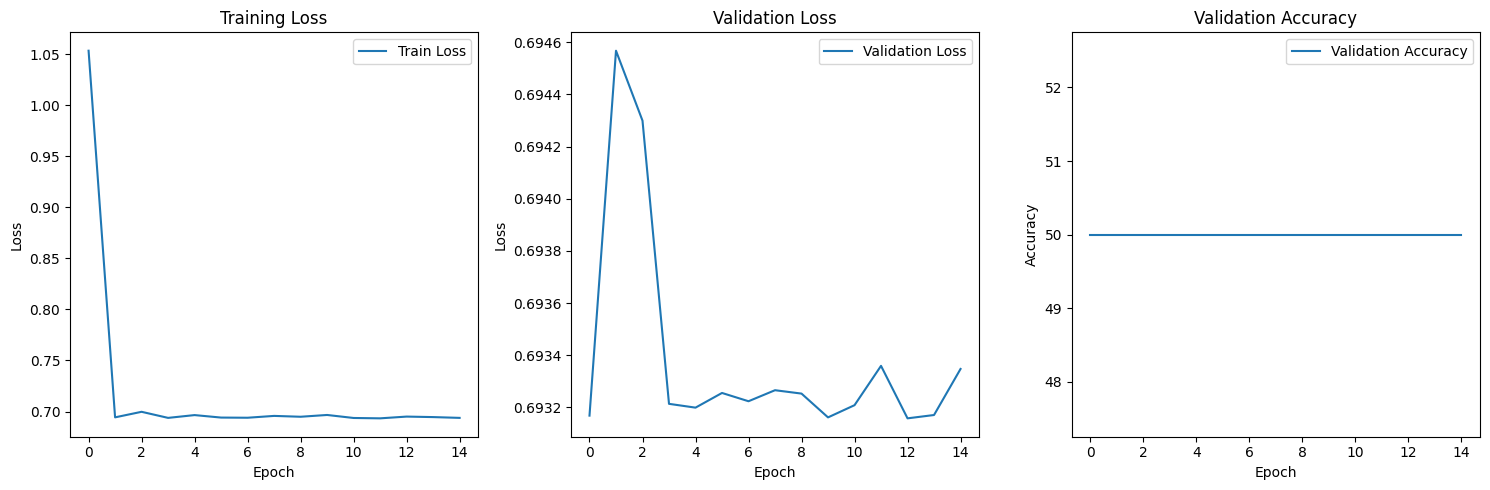

In [11]:
# Matplotlib 라이브러리를 사용하여 그래프를 그리기 위한 설정을 합니다.
plt.figure(figsize=(15, 5))  # 전체 그림의 크기를 설정합니다. (가로 15, 세로 5)

# 첫 번째 서브플롯: 훈련 손실
plt.subplot(1, 3, 1)  # 1행 3열의 첫 번째 서브플롯을 선택합니다.
plt.plot(train_losses, label='Train Loss')  # 훈련 손실을 플로팅합니다.
plt.xlabel('Epoch')  # x축 레이블을 'Epoch'으로 설정합니다.
plt.ylabel('Loss')  # y축 레이블을 'Loss'로 설정합니다.
plt.title('Training Loss')  # 그래프 제목을 'Training Loss'로 설정합니다.
plt.legend()  # 범례를 추가합니다.

# 두 번째 서브플롯: 검증 손실
plt.subplot(1, 3, 2)  # 1행 3열의 두 번째 서브플롯을 선택합니다.
plt.plot(val_losses, label='Validation Loss')  # 검증 손실을 플로팅합니다.
plt.xlabel('Epoch')  # x축 레이블을 'Epoch'으로 설정합니다.
plt.ylabel('Loss')  # y축 레이블을 'Loss'로 설정합니다.
plt.title('Validation Loss')  # 그래프 제목을 'Validation Loss'로 설정합니다.
plt.legend()  # 범례를 추가합니다.

# 세 번째 서브플롯: 검증 정확도
plt.subplot(1, 3, 3)  # 1행 3열의 세 번째 서브플롯을 선택합니다.
plt.plot(val_accuracies, label='Validation Accuracy')  # 검증 정확도를 플로팅합니다.
plt.xlabel('Epoch')  # x축 레이블을 'Epoch'으로 설정합니다.
plt.ylabel('Accuracy')  # y축 레이블을 'Accuracy'로 설정합니다.
plt.title('Validation Accuracy')  # 그래프 제목을 'Validation Accuracy'로 설정합니다.
plt.legend()  # 범례를 추가합니다.

# 서브플롯 간의 간격을 자동으로 조정하여 겹치지 않도록 합니다.
plt.tight_layout()

# 그래프를 화면에 표시합니다.
plt.show()


In [12]:
def load_and_transform_image(image_path, transform):
  # 주어진 경로에서 이미지를 로드하고 RGB 형식으로 변환
  image = Image.open(image_path).convert('RGB')

  # 이미지의 너비와 높이를 가져옴
  width, height = image.size

  # 이미지의 중앙에서 128x128 크기로 자르기 위한 좌표를 계산합니다.
  left = (width - 128) / 2  # 왼쪽 경계
  top = (height - 128) / 2   # 위쪽 경계
  right = (width + 128) / 2  # 오른쪽 경계
  bottom = (height + 128) / 2 # 아래쪽 경계

  # 계산된 좌표를 사용하여 이미지를 자릅니다.
  image_cropped = image.crop((left, top, right, bottom))

  # 변환을 적용한 이미지를 반환하고, 원본 자른 이미지를 함께 반환합니다.
  return transform(image_cropped), image_cropped

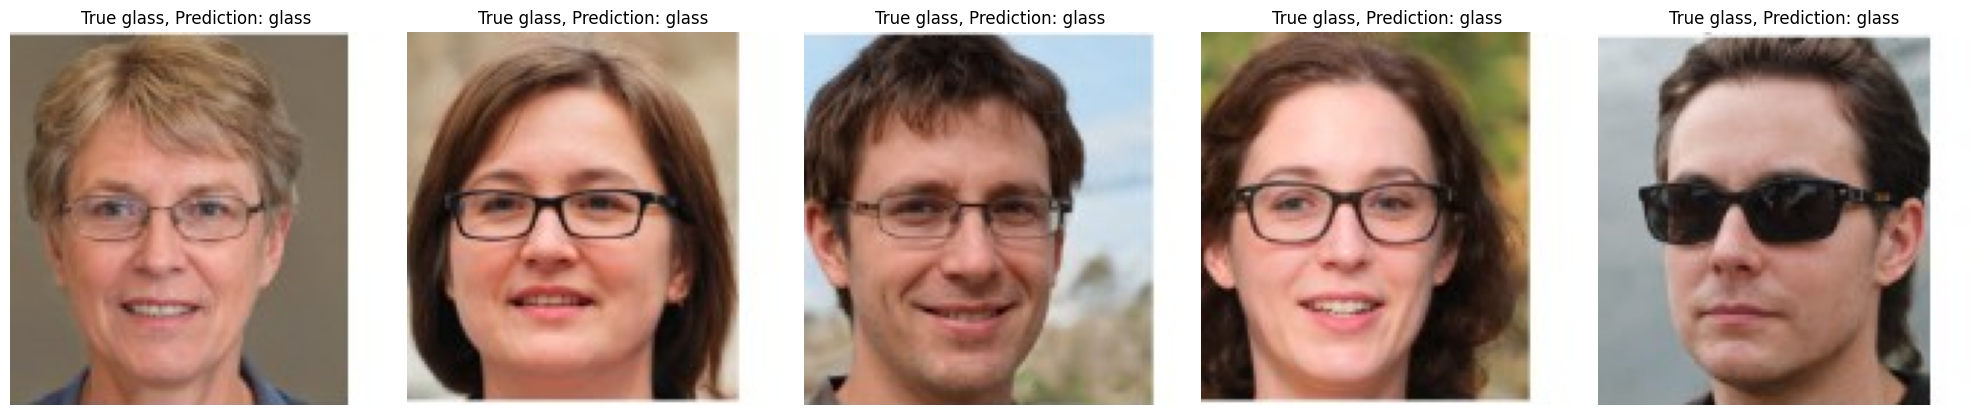

In [14]:
# 클래스 폴더 경로를 정의합니다. 각 클래스에 대한 이미지가 저장된 경로를 포함합니다.
class_folders = {
    'glass': '/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/test/glasses',
    'no_glass': '/content/drive/MyDrive/Colab Notebooks/ComputerVision/2/test/no_glasses'
}

# 플롯의 크기를 설정합니다
plt.figure(figsize=(20, 8))

# 이미지 카운터 초기화
counter = 1

# 각 클래스 이름과 해당 폴더 경로에 대해 반복합니다
for class_name, folder_path in class_folders.items():
  # 폴더 내의 모든 이미지 파일 경로를 가져옵니다
  image_paths = glob.glob(os.path.join(folder_path, '*'))

  # 각 클래스에서 첫 5개의 이미지 경로를 선택합니다
  selected_paths = image_paths[:5]

  # 선택된 이미지 경로에 대해 반복합니다
  for image_path in selected_paths:
    image, image_cropped = load_and_transform_image(image_path, transform)

    # 배치 차원을 추가하여 모델에 입력할 수 있는 형태로 변환합니다
    image_unsqueeze = image.unsqueeze(0)

    output = net(image_unsqueeze)

    # 예측 결과에서 가장 높은 확률을 가진 클래스를 선택
    _, predicted = torch.max(output, 1)

    # 예측된 클래스를 'glass' 또는 'no_glass'로 변환합니다
    prediction = 'glass' if predicted.item() == 0 else 'no_glass'

    plt.subplot(2, 5, counter)
    plt.imshow(image_cropped)
    plt.title(f'True {class_name}, Prediction: {prediction}')
    plt.axis('off')

    counter += 1

plt.tight_layout()
plt.show()